In [22]:
# Código para que los resultados no se corten
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

<IPython.core.display.Javascript object>

In [23]:
# conditional install
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install pytorch-tabnet

  from pytorch_tabnet.tab_model import TabNetClassifier

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import random
import os
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef, f1_score,precision_recall_curve
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
import seaborn as sns
from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Función para definir en un solo lugar todas las semillas
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
seed_everything(seed_value)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Leemos el archivo y seleccionamos las features

In [26]:
df = pd.read_csv('postprandial_hypoglycemias.csv')

selected_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared',
                'cob','next_iob','iob','aob_3h','aob_6h','hour']

target = 'hypoglycemia'
df = df[selected_features + [target]]
df = df.dropna()
df = df.reset_index(drop=True)
X = df.drop(target, axis=1)
y = df[target]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Separamos los datos en grupos de entrenamiento, validación y test, procurando que todas tengan el mismo porcentaje de datos con hipoglicemia con stratify

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
print(f'Total de registros: {len(df)}')
print(f'Total de registros con hipoglicemia: {np.count_nonzero(y == 1)}')
print(f'Total de registros datos de entrenamiento: {len(y_train)}')
print(f'Total de registros datos de entrenamiento con hipoglicemia: {np.count_nonzero(y_train == 1)}')
print(f'Total de registros datos de test: {len(y_test)}')
print(f'Total de registros datos de test con hipoglicemia: {np.count_nonzero(y_test == 1)}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total de registros: 654
Total de registros con hipoglicemia: 104
Total de registros datos de entrenamiento: 457
Total de registros datos de entrenamiento con hipoglicemia: 73
Total de registros datos de test: 197
Total de registros datos de test con hipoglicemia: 31


Calculamos los pesos de cada clase para pasar como parámetro al modelo

In [29]:
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{0: 0.5950520833333334, 1: 3.1301369863013697}


In [30]:
# Implementación de la métrica para F1 score
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        return f1_score(y_true, y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Implementación de la métrica para MCC
class MCC(Metric):
    def __init__(self):
        self._name = "MCC"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        if mcc_denominator == 0:
            return 0
        else:
            return mcc_numerator / mcc_denominator

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Entrenamiento del modelo en TabNet

In [32]:
evaluation_metrics = ['MCC','auc']
n_steps = 5
gamma = 1.3
patience = 50
epochs = 150
aug = ClassificationSMOTE(p=0.3)
batch_size = 64
virtual_batch_size = 8
classifier = TabNetClassifier(
                              verbose=1,
                              n_steps=n_steps,
                              gamma = gamma
                              )

classifier.fit(
               X_train=X_train.values, y_train=y_train,
               eval_set=[(X_train.values, y_train)],
               eval_name=['train'],
               batch_size=batch_size,
               virtual_batch_size=virtual_batch_size,
               patience=patience,
               max_epochs=epochs,
               weights=class_weights_dict,
               drop_last=True,
               eval_metric= evaluation_metrics,
               augmentations=aug
               )



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22008 | train_MCC: 0.02172 | train_auc: 0.48275 |  0:00:00s
epoch 1  | loss: 0.80217 | train_MCC: 0.03398 | train_auc: 0.53107 |  0:00:01s
epoch 2  | loss: 0.72839 | train_MCC: 0.0681  | train_auc: 0.56567 |  0:00:01s
epoch 3  | loss: 0.73984 | train_MCC: 0.08671 | train_auc: 0.56136 |  0:00:02s
epoch 4  | loss: 0.65839 | train_MCC: 0.06504 | train_auc: 0.56418 |  0:00:02s
epoch 5  | loss: 0.65116 | train_MCC: 0.04941 | train_auc: 0.55854 |  0:00:03s
epoch 6  | loss: 0.66835 | train_MCC: 0.08736 | train_auc: 0.57417 |  0:00:03s
epoch 7  | loss: 0.66196 | train_MCC: 0.13294 | train_auc: 0.63007 |  0:00:04s
epoch 8  | loss: 0.67374 | train_MCC: 0.11794 | train_auc: 0.6331  |  0:00:04s
epoch 9  | loss: 0.68906 | train_MCC: 0.17997 | train_auc: 0.63085 |  0:00:05s
epoch 10 | loss: 0.65989 | train_MCC: 0.21606 | train_auc: 0.67619 |  0:00:06s
epoch 11 | loss: 0.66112 | train_MCC: 0.16646 | train_auc: 0.68486 |  0:00:07s
epoch 12 | loss: 0.65009 | train_MCC: 0.19585 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Métricas durante el entrenamiento

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

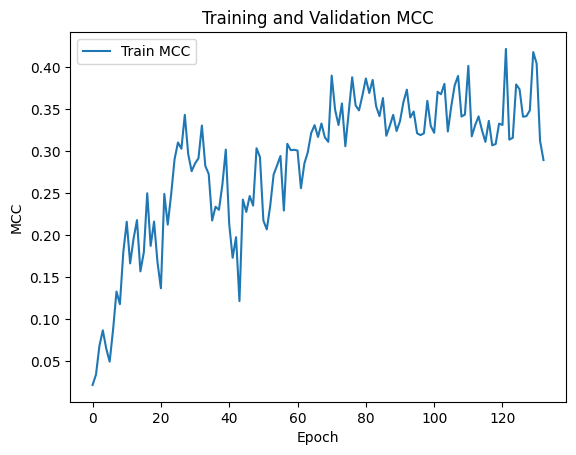

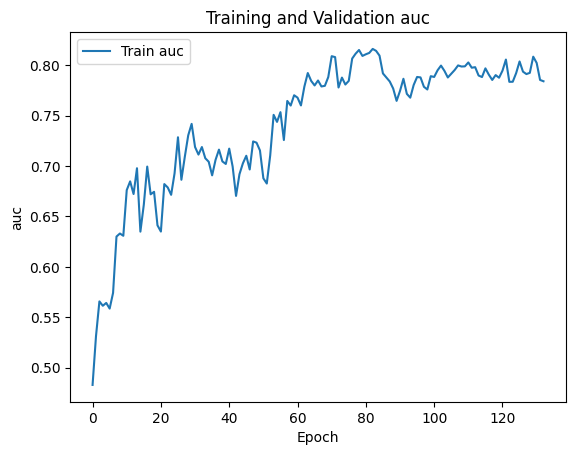

In [34]:
for metric in evaluation_metrics:
    plt.figure()
    plt.plot(classifier.history['train_' + metric], label='Train ' + metric)
    plt.title('Training and Validation ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

**Obtenemos las predicciones a partir del umbral indicado y los datos de test**

In [35]:
y_pred_probs = classifier.predict_proba(X_test.values)[:,1]
threshold = 0.52
y_pred = (y_pred_probs >= threshold).astype(int)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Curva ROC**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

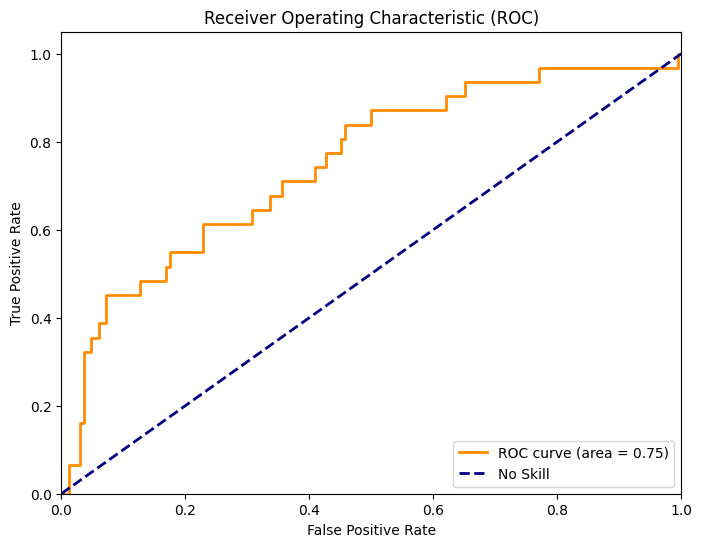

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Matriz de confusión**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

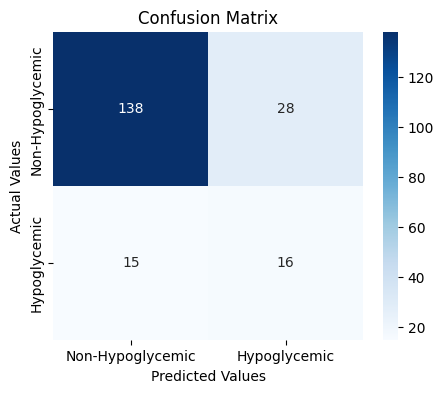

In [37]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                     columns = ['Non-Hypoglycemic', 'Hypoglycemic'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Resumen métricas modelo TabNet**

In [38]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

report = classification_report(y_test, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)

f1Score = report['Hypoglycemic']['f1-score']

mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_acuracy = balanced_accuracy_score(y_test, y_pred)

metrics = {
    'Accuracy': accuracy.round(2),
    'Sensitivity': sensitivity.round(2),
    'Specificity': specificity.round(2),
    'ROC AUC': roc_auc.round(2),
    'F1 Score (Hypoglycemia class)': round(f1Score,2),
    'MCC': mcc.round(2),
    'Balanced accuracy': balanced_acuracy,
    'Classification Report': report
}

metrics

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'Accuracy': 0.78,
 'Sensitivity': 0.52,
 'Specificity': 0.83,
 'ROC AUC': 0.75,
 'F1 Score (Hypoglycemia class)': 0.43,
 'MCC': 0.3,
 'Balanced accuracy': 0.673727166731442,
 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.9019607843137255,
   'recall': 0.8313253012048193,
   'f1-score': 0.8652037617554859,
   'support': 166},
  'Hypoglycemic': {'precision': 0.36363636363636365,
   'recall': 0.5161290322580645,
   'f1-score': 0.4266666666666667,
   'support': 31},
  'accuracy': 0.7817258883248731,
  'macro avg': {'precision': 0.6327985739750446,
   'recall': 0.673727166731442,
   'f1-score': 0.6459352142110762,
   'support': 197},
  'weighted avg': {'precision': 0.8172498348670341,
   'recall': 0.7817258883248731,
   'f1-score': 0.7961953863861793,
   'support': 197}}}

**Mostramos las features ordenadas por importancia del modelo**

In [39]:
feature_importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string(index=False))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

            Feature  Importance
            glucose    0.268282
              basal    0.182061
glucose_rate_change    0.118931
         glucose_1h    0.098366
                cob    0.083611
       bolus_normal    0.061595
      glucose_range    0.054742
               hour    0.042904
                iob    0.042260
total_bolus_squared    0.023486
    mean_glucose_1h    0.020634
                cho    0.003119
             aob_6h    0.000008
        glucose_30m    0.000000
           next_iob    0.000000
             aob_3h    0.000000


**Gráfica interpretabilidad general del modelo**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

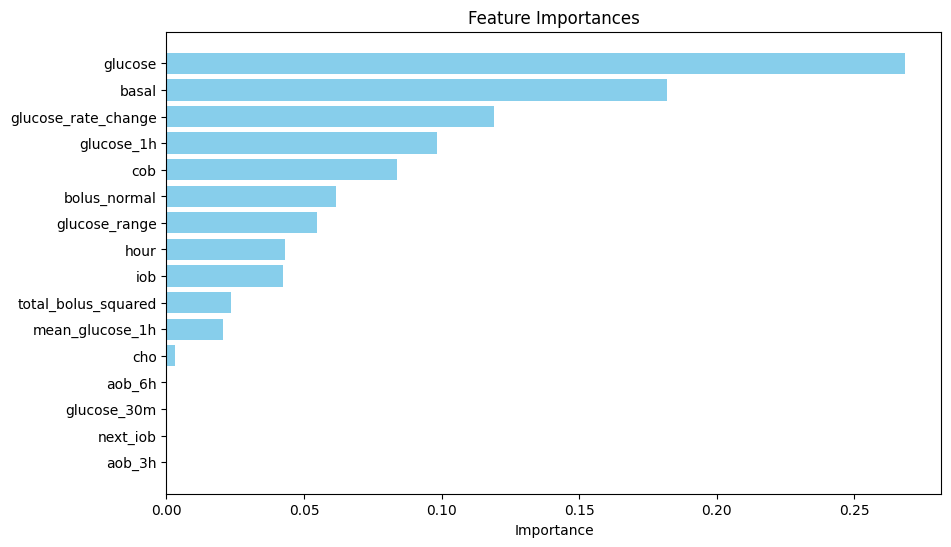

In [40]:
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**Interpretabilidad del grupo test por instancia y máscara**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

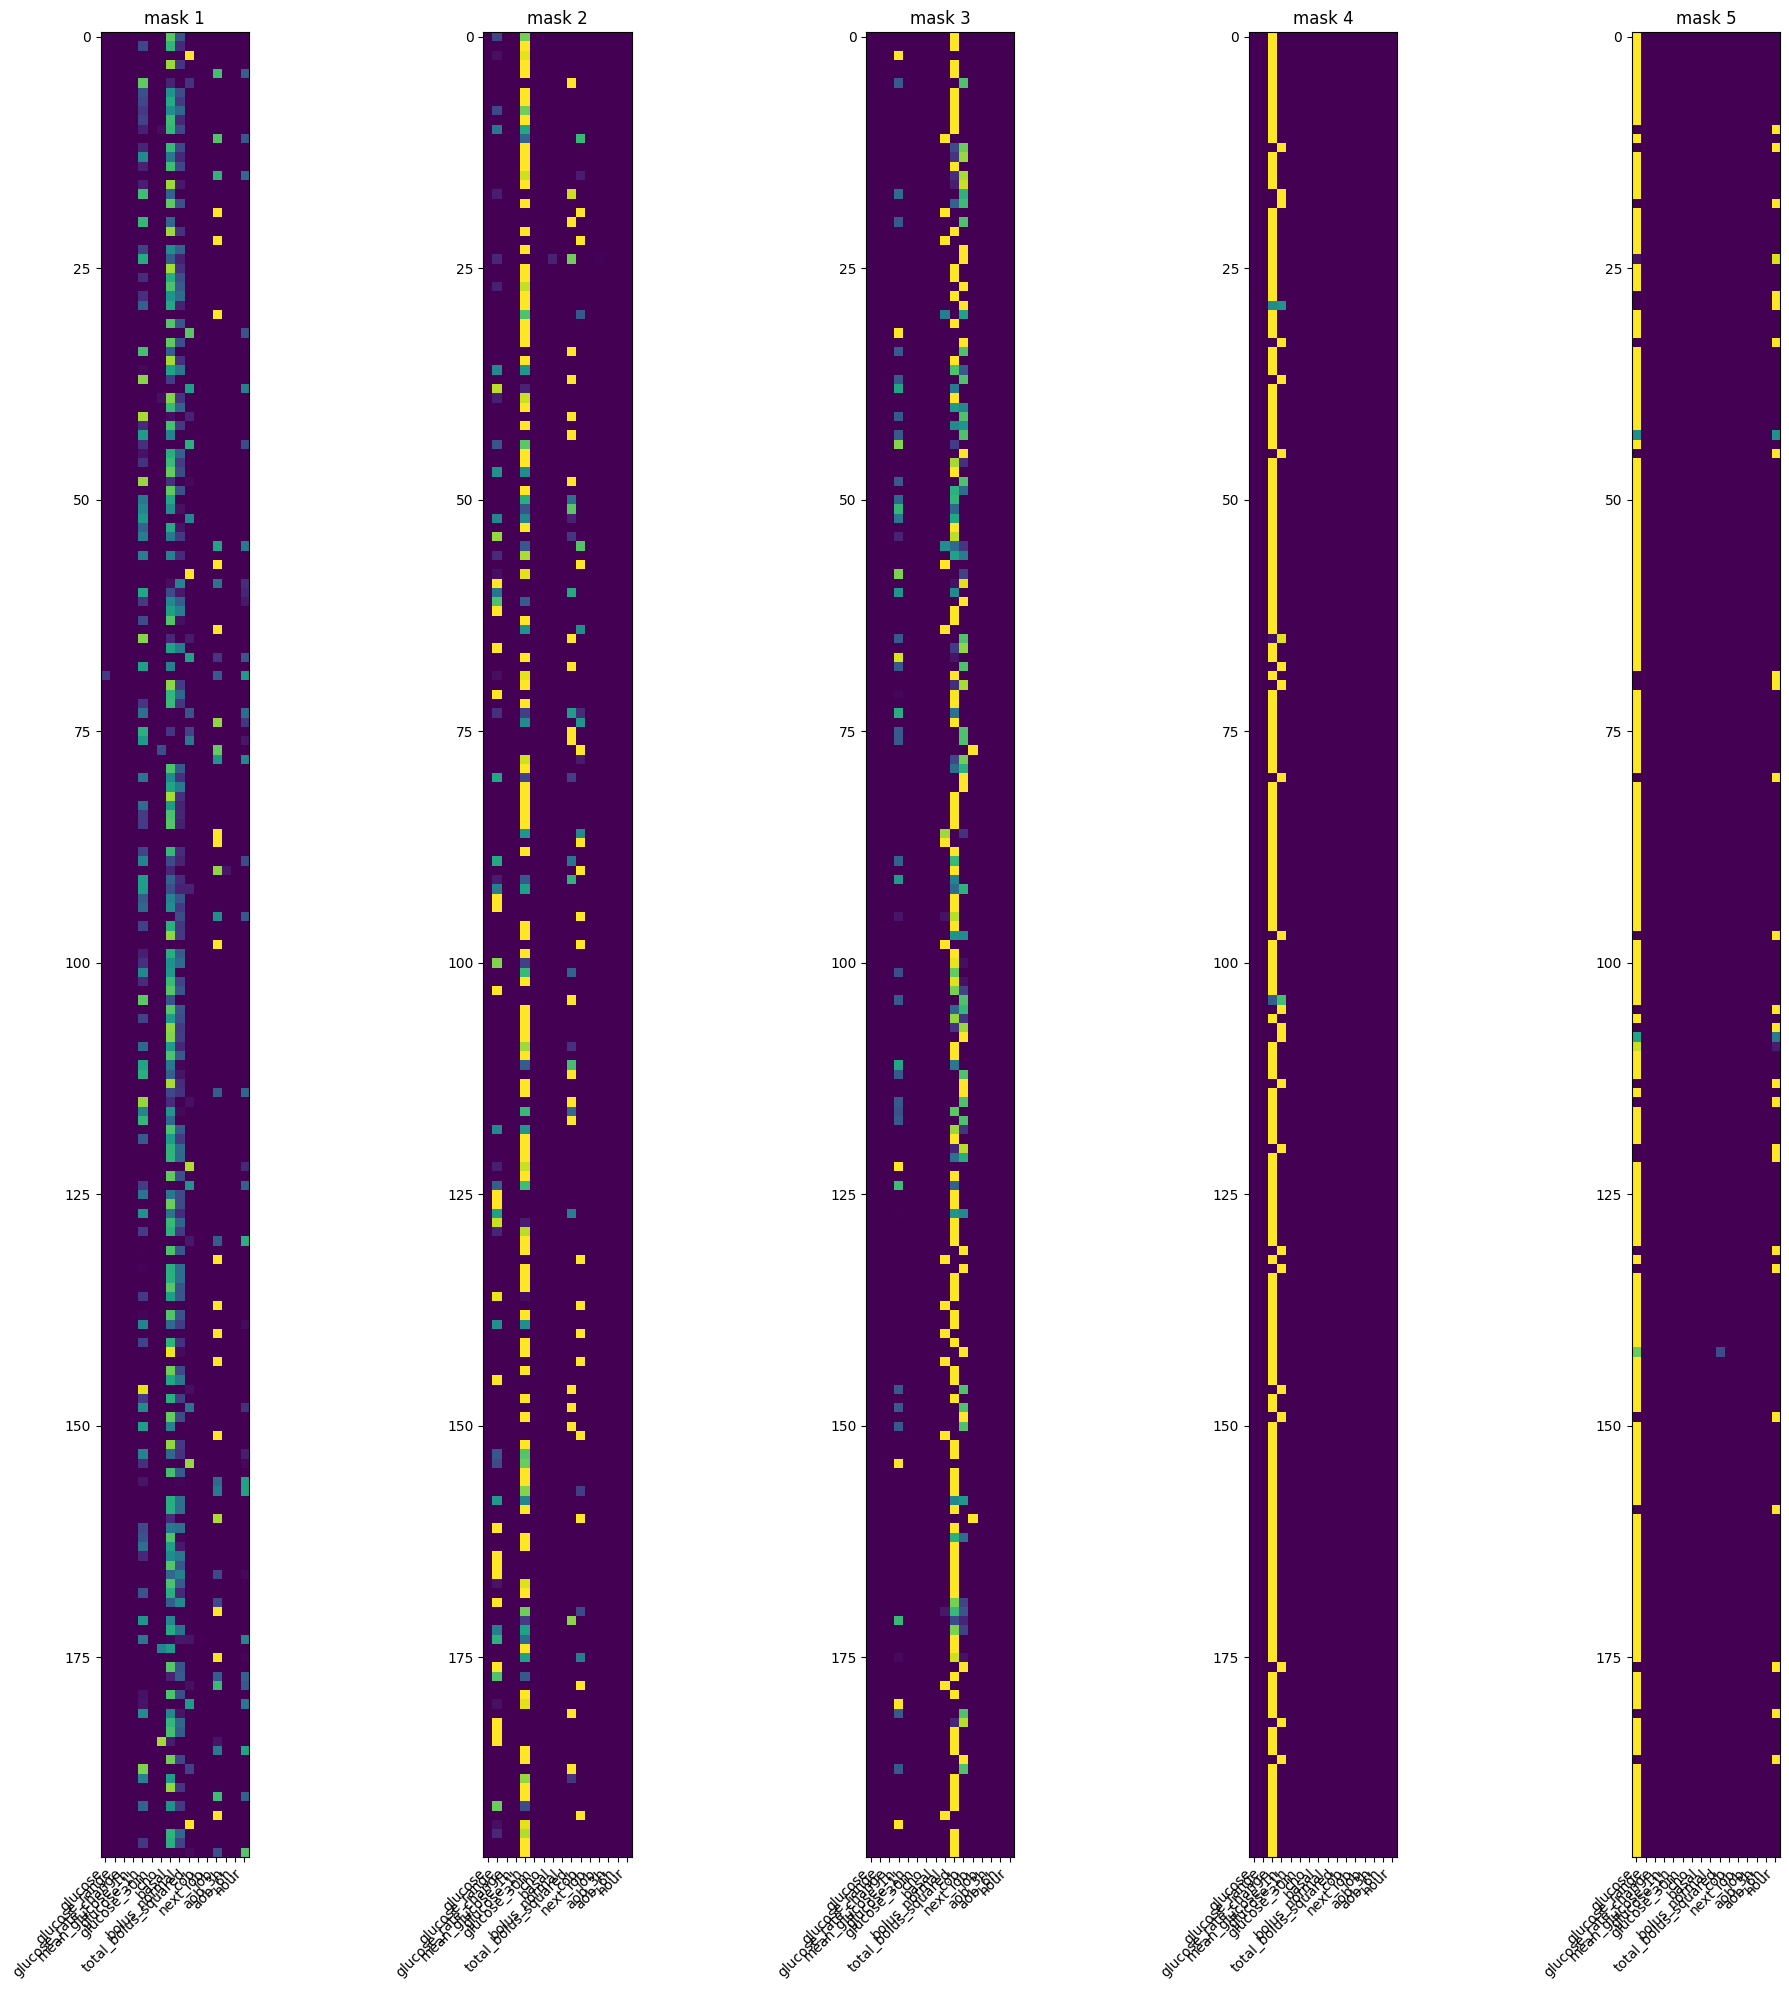

In [41]:
explain_matrix, masks = classifier.explain(X_test.values)
n_steps = len(masks)
fig, axs = plt.subplots(1, n_steps, figsize=(20, 20))

for i in range(n_steps):
    axs[i].imshow(masks[i][:len(X_test.values)])
    axs[i].set_title(f"mask {i + 1}")
    axs[i].set_xticks(range(len(selected_features)))
    axs[i].set_xticklabels(labels=selected_features, rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Interpretabilidad del grupo test agregada**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

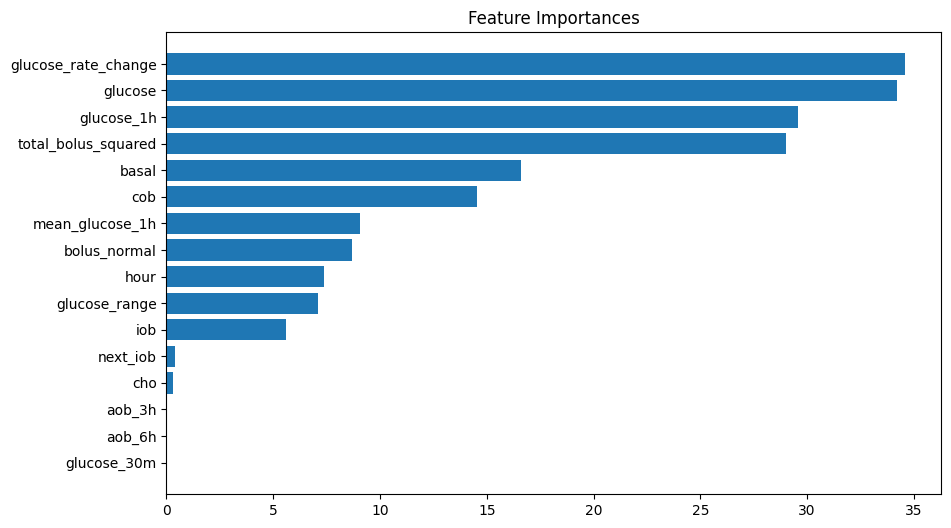

In [42]:
sum_of_features = None

# Sumar las importancias de las características de todas las máscaras
for mask in masks.values():
    if sum_of_features is None:
        sum_of_features = np.sum(mask, axis=0)
    else:
        sum_of_features += np.sum(mask, axis=0)

# Calcular el promedio dividiendo por el número total de máscaras
average_features = sum_of_features / len(masks)

# Ordenar las características y sus importancias promedio de mayor a menor
sorted_indices = np.argsort(average_features)[::-1]
sorted_features = np.array(selected_features)[sorted_indices]
sorted_importances = average_features[sorted_indices]

# Visualización con barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()